# Versatility of GPT-2 for Tasks in other Domains:

tasks: Bit Memory

In [64]:
#@title Install Package
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [65]:
#@title Import Package
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
from transformers.models.gpt2.modeling_gpt2 import GPT2Model
from typing import List, Dict
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import requests
from PIL import Image
import cv2

%matplotlib inline 

## Task 2: Bit Memory.

### part A: Loading the dataset

Simple logic of the generate the data

In [82]:
if torch.cuda.is_available():
   device = 'cuda'
else:
  device = 'cpu'

Create the dataset

In [91]:
class BitMemoryDataset(torch.utils.data.Dataset):
  def __init__(self,bit_length =1000, num_patterns=5, size = 100):
    self.bit_length = bit_length
    self.num_patterns = num_patterns
    self.size = size

  def __len__(self):
    return self.size

  def __getitem__(self, idx):
    bits = np.random.randint(low=0, high=2, size=(1, self.num_patterns, self.bit_length))
    bits = 2 * bits - 1
    query_inds = np.random.randint(low=0, high=self.num_patterns, size=1)
    query_bits = bits[range(1), query_inds]
    mask = np.random.randint(low=1, high=2, size=query_bits.shape)
    masked_query_bits = mask * query_bits
    masked_query_bits = masked_query_bits.reshape(1, 1, self.bit_length)
    x = np.concatenate([bits, masked_query_bits], axis=1)
    y = query_bits

    return torch.tensor(x, dtype=torch.float32).squeeze(), torch.tensor(y, dtype=torch.long).squeeze()



def generate_data_loaders(size = 100,bit_length = 1000, batch_size = 1, train_size=0.8):
  dataset = BitMemoryDataset(bit_length = bit_length, size=size)
  train_size = int(train_size * len(dataset))
  test_size = len(dataset) - train_size
  train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  return train_loader, test_loader

### part B: Modified the pretained transformer to our specific tasks
Load the pretain transformer GPT2-model and freeze the weights of the self-attention and feedforward layers.



In [92]:
# load the GP2 model
gpt2 = GPT2Model.from_pretrained('gpt2')

In [93]:
# show the name of all the para your are able to modified in this model
for name, param in gpt2.named_parameters():
  print(name)

wte.weight
wpe.weight
h.0.ln_1.weight
h.0.ln_1.bias
h.0.attn.c_attn.weight
h.0.attn.c_attn.bias
h.0.attn.c_proj.weight
h.0.attn.c_proj.bias
h.0.ln_2.weight
h.0.ln_2.bias
h.0.mlp.c_fc.weight
h.0.mlp.c_fc.bias
h.0.mlp.c_proj.weight
h.0.mlp.c_proj.bias
h.1.ln_1.weight
h.1.ln_1.bias
h.1.attn.c_attn.weight
h.1.attn.c_attn.bias
h.1.attn.c_proj.weight
h.1.attn.c_proj.bias
h.1.ln_2.weight
h.1.ln_2.bias
h.1.mlp.c_fc.weight
h.1.mlp.c_fc.bias
h.1.mlp.c_proj.weight
h.1.mlp.c_proj.bias
h.2.ln_1.weight
h.2.ln_1.bias
h.2.attn.c_attn.weight
h.2.attn.c_attn.bias
h.2.attn.c_proj.weight
h.2.attn.c_proj.bias
h.2.ln_2.weight
h.2.ln_2.bias
h.2.mlp.c_fc.weight
h.2.mlp.c_fc.bias
h.2.mlp.c_proj.weight
h.2.mlp.c_proj.bias
h.3.ln_1.weight
h.3.ln_1.bias
h.3.attn.c_attn.weight
h.3.attn.c_attn.bias
h.3.attn.c_proj.weight
h.3.attn.c_proj.bias
h.3.ln_2.weight
h.3.ln_2.bias
h.3.mlp.c_fc.weight
h.3.mlp.c_fc.bias
h.3.mlp.c_proj.weight
h.3.mlp.c_proj.bias
h.4.ln_1.weight
h.4.ln_1.bias
h.4.attn.c_attn.weight
h.4.attn.c_at

In [94]:
for name, param in gpt2.named_parameters():
# freeze all parameters except the layernorm and positional embeddings 
  if 'ln' in name or 'wpe' in name:
    param.requires_grad = True 
  else:
    param.requires_grad = False

Design and train your own network using pretrained GPT2 model as universal computational engine. You need to design

*   An input embedding layer, which projects your input to accommodate GPT2 input demension

*   An output Linear layer and loss function

In [95]:
class Bit_Memory_transformer(nn.Module):
  def __init__(self, engine,input_dim, engine_embed_dim, n_class, patch_size):
    super().__init__()
    self.input_dim = input_dim
    self.output_dim = n_class
    self.input_embed = nn.Linear(input_dim, engine_embed_dim)
    self.engine = engine
    self.output_layer = nn.Linear(engine_embed_dim, n_class)
  def forward(self, x):
        orig_dim = x.shape[-1]
        ratio = orig_dim // self.input_dim
        x = x.reshape(x.shape[0], x.shape[1] * ratio, self.input_dim)
        flattened_input = x.view(-1, 50)

        x = self.input_embed(flattened_input)
        
        x = self.engine(inputs_embeds = x.unsqueeze(0)).last_hidden_state
        x = x[:,-ratio:]
        x = self.output_layer(x)

        x = x.reshape(x.shape[0], x.shape[1] // ratio, ratio * self.output_dim)
        return x
        

    

In [96]:
ce_loss = torch.nn.CrossEntropyLoss()
def loss_fn(out, y, x=None, bit_length = 1000):
  out = torch.reshape(out, (-1, bit_length, 2))
  ids = torch.zeros(y.shape).to(device=y.device).long()
  ids[y < 0], ids[y > 0] = 0, 1
  out, ids = torch.reshape(out, (-1, 2)), torch.reshape(ids, (-1,))
  return ce_loss(out, ids)

def accuracy_fn(preds, true, x=None, bit_length = 1000):
        preds = preds.reshape(-1, bit_length, 2).argmax(-1) * 2 - 1
        return (np.sign(preds) == np.sign(true)).mean()

def get_loss(x,y,bit_length ,return_acc = True):
  out = model(x)
  loss = loss_fn(out, y, x=x, bit_length = bit_length)
  accs = accuracy_fn(
                out.detach().cpu().numpy(),
                y.detach().cpu().numpy(),
                x=x.detach().cpu().numpy(),
                bit_length = bit_length
            )
  return loss, accs

In [98]:
model = Bit_Memory_transformer(
    gpt2, 
    input_dim = 50, 
    engine_embed_dim = 768,
    n_class= 2*50,
    patch_size = 50
)


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Val Accuracy')

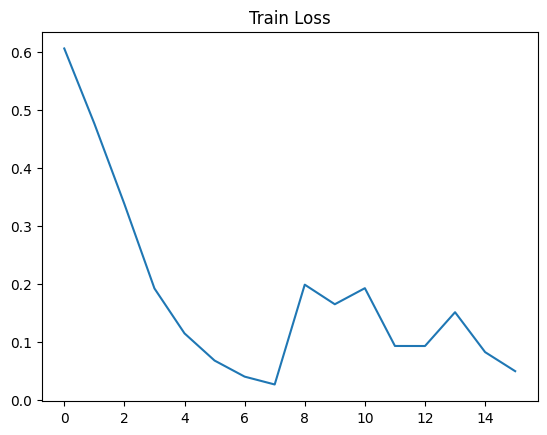

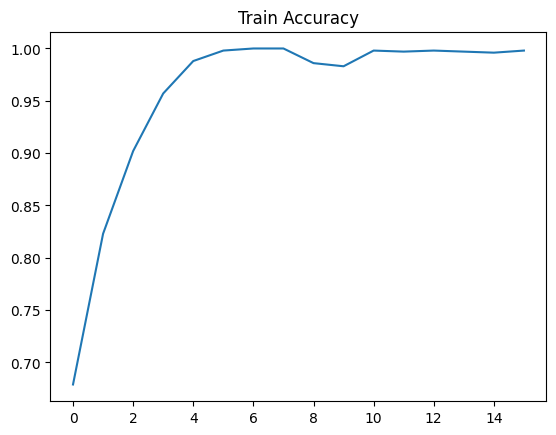

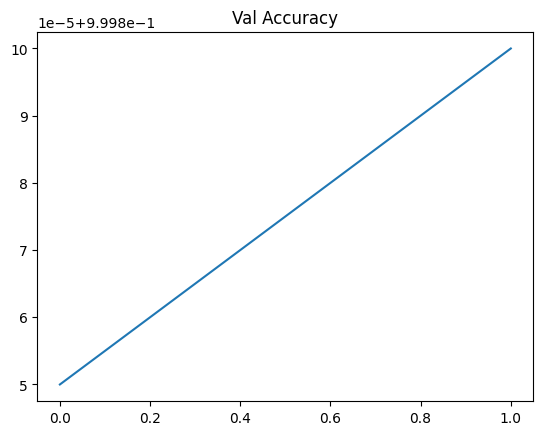

In [99]:
bit_length = 1000
data_size = 100

train_loader, test_loader = generate_data_loaders(bit_length = bit_length, size = data_size, batch_size=1, train_size=0.8)

# define the optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

losses = []
train_acc = []
all_val_acc = []
best_val_acc = 0
num_epochs = 2

epoch_iterator = trange(num_epochs)
for epoch in epoch_iterator:
    # Training loop
    data_iterator = tqdm(train_loader)
    for i, (inputs, labels) in enumerate(data_iterator):
      loss, acc = get_loss(inputs, labels,bit_length, return_acc=True)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      data_iterator.set_postfix(loss=loss.item())

      if (i + 1) % 10 == 0:
            losses.append(loss.item())
            train_acc.append(acc.item())

    # validation loop
    val_acc = []
    model.eval()
    with torch.no_grad():
      for inputs, labels in test_loader:
        loss, acc = get_loss(inputs, labels,bit_length, return_acc=True)
        val_acc.append(acc.item())
    model.train()

    all_val_acc.append(np.mean(val_acc))
    # Save best model
    if np.mean(val_acc) > best_val_acc:
        best_val_acc = np.mean(val_acc)

    epoch_iterator.set_postfix(val_acc=np.mean(val_acc), best_val_acc=best_val_acc)

plt.plot(losses)
plt.title('Train Loss')
plt.figure()
plt.plot(train_acc)
plt.title('Train Accuracy')
plt.figure()
plt.plot(all_val_acc)
plt.title('Val Accuracy')